In [ ]:
# default_exp models.TSiTPlus

# TSiT

> This is a PyTorch implementation created by Ignacio Oguiza (timeseriesAI@gmail.com) based on ViT (Vision Transformer)
     
Reference: 

     Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., ... & Houlsby, N. (2020).
     An image is worth 16x16 words: Transformers for image recognition at scale. arXiv preprint arXiv:2010.11929.

     This implementation is a modified version of Vision Transformer that is part of the great timm library
     (https://github.com/rwightman/pytorch-image-models/blob/72b227dcf57c0c62291673b96bdc06576bb90457/timm/models/vision_transformer.py)

In [ ]:
#export
from tsai.imports import *
from tsai.models.utils import *
from tsai.models.layers import *
from typing import Callable

In [ ]:
#export
class _TSiTEncoderLayer(nn.Module):
    def __init__(self, d_model:int, n_heads:int, attn_dropout:float=0., dropout:float=0, drop_path_rate:float=0., 
                 mlp_ratio:int=1, qkv_bias:bool=True, act:str='reglu', pre_norm:bool=False):
        super().__init__()
        self.mha =  MultiheadAttention(d_model, n_heads, attn_dropout=attn_dropout, proj_dropout=dropout, qkv_bias=qkv_bias)
        self.attn_norm = nn.LayerNorm(d_model)
        self.pwff =  PositionwiseFeedForward(d_model, dropout=dropout, act=act, mlp_ratio=mlp_ratio)
        self.ff_norm = nn.LayerNorm(d_model)
        self.drop_path = DropPath(drop_path_rate) if drop_path_rate != 0 else nn.Identity()
        self.pre_norm = pre_norm

    def forward(self, x):
        if self.pre_norm:
            x = self.drop_path(self.mha(self.attn_norm(x))[0]) + x
            x = self.drop_path(self.pwff(self.ff_norm(x))) + x
        else:
            x = self.attn_norm(self.drop_path(self.mha(x)[0]) + x)
            x = self.ff_norm(self.drop_path(self.pwff(x)) + x)
        return x

In [ ]:
# export
class _TSiTEncoder(nn.Module):
    def __init__(self, d_model, n_heads, depth:int=6, attn_dropout:float=0., dropout:float=0, drop_path_rate:float=0., 
                 mlp_ratio:int=1, qkv_bias:bool=True, act:str='reglu', pre_norm:bool=False):
        super().__init__()
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]
        layers = []
        for i in range(depth):
            layer = _TSiTEncoderLayer(d_model, n_heads, attn_dropout=attn_dropout, dropout=dropout, drop_path_rate=dpr[i], 
                                      mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, act=act, pre_norm=pre_norm)
            layers.append(layer)
        self.encoder = nn.Sequential(*layers)
        self.norm = nn.LayerNorm(d_model) if pre_norm else nn.Identity()

    def forward(self, x):
        x = self.encoder(x)
        x = self.norm(x)
        return x

In [ ]:
# export
class _TSiTBackbone(Module):
    def __init__(self, c_in:int, seq_len:int, depth:int=6, d_model:int=128, n_heads:int=16, d_head:Optional[int]=None, act:str='reglu', d_ff:int=256, 
                 qkv_bias:bool=True, attn_dropout:float=0., dropout:float=0., drop_path_rate:float=0., mlp_ratio:int=1, 
                 pre_norm:bool=False, use_token:bool=True,  use_pe:bool=True, n_embeds:Optional[list]=None, embed_dims:Optional[list]=None, 
                 cat_pos:Optional[list]=None, feature_extractor:Optional[Callable]=None):

        # Categorical embeddings
        if n_embeds is not None:
            if embed_dims is None:  
                embed_dims = [emb_sz_rule(s) for s in n_embeds]
            self.to_cat_embed = MultiEmbedding(c_in, n_embeds, embed_dims=embed_dims, cat_pos=cat_pos)
            c_in = c_in + sum(embed_dims) - len(n_embeds)
        else:
            self.to_cat_embed = nn.Identity()

        # Feature extractor
        if feature_extractor:
            if isinstance(feature_extractor, nn.Module):  self.feature_extractor = feature_extractor
            else: self.feature_extractor = feature_extractor(c_in, d_model)
            c_in, seq_len = output_size_calculator(self.feature_extractor, c_in, seq_len)
        else:
            self.feature_extractor = nn.Conv1d(c_in, d_model, 1)
        self.transpose = Transpose(1,2)

        # Position embedding & token
        if use_pe:
            self.pos_embed = nn.Parameter(torch.zeros(1, seq_len + use_token, d_model))
        self.use_pe = use_pe
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.use_token = use_token
        self.emb_dropout = nn.Dropout(dropout)

        # Encoder
        self.encoder = _TSiTEncoder(d_model, n_heads, depth=depth, qkv_bias=qkv_bias, dropout=dropout,
                                    mlp_ratio=mlp_ratio, drop_path_rate=drop_path_rate, act=act, pre_norm=pre_norm)

    def forward(self, x):

        # Categorical embeddings
        x = self.to_cat_embed(x)

        # Feature extractor
        x = self.feature_extractor(x)
        
        # Position embedding & token
        x = self.transpose(x)
        if self.use_token:
            x = torch.cat((self.cls_token.expand(x.shape[0], -1, -1), x), dim=1)
        if self.use_pe: 
            x = x + self.pos_embed
        x = self.emb_dropout(x)

        # Encoder
        x = self.encoder(x)
        x = x.transpose(1,2)
        if self.use_token:
            x = x[..., 0]
        return x

In [ ]:
#exports
class TSiTPlus(nn.Sequential):
    r"""Time series transformer model based on ViT (Vision Transformer):

    Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., ... & Houlsby, N. (2020).
    An image is worth 16x16 words: Transformers for image recognition at scale. arXiv preprint arXiv:2010.11929.

    This implementation is a modified version of Vision Transformer that is part of the grat timm library
    (https://github.com/rwightman/pytorch-image-models/blob/72b227dcf57c0c62291673b96bdc06576bb90457/timm/models/vision_transformer.py)

    Args:
        c_in:              the number of features (aka variables, dimensions, channels) in the time series dataset.
        c_out:             the number of target classes.
        seq_len:           number of time steps in the time series.
        depth:             number of blocks in the encoder.
        d_model:           total dimension of the model (number of features created by the model).
        n_heads:           parallel attention heads. Default:16 (range(8-16)).
        d_head:            size of the learned linear projection of queries, keys and values in the MHA. 
                           Default: None -> (d_model/n_heads) = 32.
        act:               the activation function of positionwise feedforward layer.
        d_ff:              the dimension of the feedforward network model. 
        attn_dropout:      dropout rate applied to the attention sublayer.
        dropout:           dropout applied to to the embedded sequence steps after position embeddings have been added and 
                           to the mlp sublayer in the encoder.
        drop_path_rate:    stochastic depth rate.
        mlp_ratio:         ratio of mlp hidden dim to embedding dim.
        qkv_bias:          determines whether bias is applied to the Linear projections of queries, keys and values in the MultiheadAttention
        pre_norm:          if True normalization will be applied as the first step in the sublayers. Defaults to False.
        use_token:         if True, the output will come from the transformed token. Otherwise a pooling layer will be applied.
        use_pe:            flag to indicate if positional embedding is used.
        fc_dropout:        dropout applied to the final fully connected layer.
        use_bn:            flag that indicates if batchnorm will be applied to the head.
        y_range:           range of possible y values (used in regression tasks).
        n_embeds:          list with the sizes of the dictionaries of embeddings (int)
        embed_dims:        list with the sizes of each embedding vector (int)
        cat_pos:           list with the position of the categorical variables in the input
        feature_extractor: an nn.Module or optional callable that will be used to preprocess the time series before 
                           the embedding step. It is useful to extract features or resample the time series.
        custom_head:       custom head that will be applied to the network. It must contain all kwargs (pass a partial function)

    Input:
        x: bs (batch size) x nvars (aka features, variables, dimensions, channels) x seq_len (aka time steps)
    """

    def __init__(self, c_in:int, c_out:int, seq_len:int, d_model:int=128, depth:int=6, n_heads:int=16, d_head:Optional[int]=None, act:str='reglu',
                 d_ff:int=256, attn_dropout:float=0., dropout:float=0., drop_path_rate:float=0., mlp_ratio:int=1, qkv_bias:bool=True, pre_norm:bool=False, 
                 use_token:bool=True, use_pe:bool=True, fc_dropout:float=0., use_bn:bool=False, y_range:Optional[tuple]=None, 
                 n_embeds:Optional[list]=None, embed_dims:Optional[list]=None, cat_pos:Optional[list]=None, 
                 feature_extractor:Optional[Callable]=None, custom_head:Optional[Callable]=None):

        backbone = _TSiTBackbone(c_in, seq_len, depth=depth, d_model=d_model, n_heads=n_heads, d_head=d_head, act=act,
                                 d_ff=d_ff, attn_dropout=attn_dropout, dropout=dropout, drop_path_rate=drop_path_rate, 
                                 pre_norm=pre_norm, mlp_ratio=mlp_ratio, use_pe=use_pe, use_token=use_token, 
                                 n_embeds=n_embeds, embed_dims=embed_dims, cat_pos=cat_pos, feature_extractor=feature_extractor)

        self.head_nf = d_model
        self.c_out = c_out
        self.seq_len = seq_len

        # Head
        if custom_head:
            if isinstance(custom_head, nn.Module): head = custom_head
            else: head = custom_head(self.head_nf, c_out, seq_len)
        else:
            layers = [LinBnDrop(d_model, c_out, bn=use_bn, p=fc_dropout)]
            if y_range: layers += [SigmoidRange(*y_range)]
            head = nn.Sequential(*layers)
        super().__init__(OrderedDict([('backbone', backbone), ('head', head)]))
        
        
TSiT = TSiTPlus

In [ ]:
bs = 16
nvars = 4
seq_len = 50
c_out = 2
xb = torch.rand(bs, nvars, seq_len)
model = TSiTPlus(nvars, c_out, seq_len, attn_dropout=.1, dropout=.1)
test_eq(model(xb).shape, (bs, c_out))
model

TSiTPlus(
  (backbone): _TSiTBackbone(
    (to_cat_embed): Identity()
    (feature_extractor): Conv1d(4, 128, kernel_size=(1,), stride=(1,))
    (transpose): Transpose(1, 2)
    (emb_dropout): Dropout(p=0.1, inplace=False)
    (encoder): _TSiTEncoder(
      (encoder): Sequential(
        (0): _TSiTEncoderLayer(
          (mha): MultiheadAttention(
            (W_Q): Linear(in_features=128, out_features=128, bias=True)
            (W_K): Linear(in_features=128, out_features=128, bias=True)
            (W_V): Linear(in_features=128, out_features=128, bias=True)
            (sdp_attn): ScaledDotProductAttention(
              (attn_dropout): Dropout(p=0.0, inplace=False)
            )
            (to_out): Sequential(
              (0): Linear(in_features=128, out_features=128, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
          (attn_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (pwff): PositionwiseFeedForward(
        

In [ ]:
bs = 16
nvars = 4
seq_len = 50
c_out = 2
xb = torch.rand(bs, nvars, seq_len)
model = TSiTPlus(nvars, c_out, seq_len)
test_eq(model(xb).shape, (bs, c_out))

## Feature extractor

It's a known fact that transformers cannot be directly applied to long sequences. To avoid this, we have included a way to subsample the sequence to generate a more manageable input.

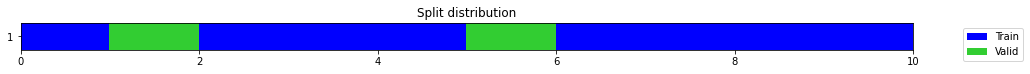

TSTensor(samples:8, vars:3, len:5000, device=cpu)

In [ ]:
from tsai.data.validation import get_splits
from tsai.data.core import get_ts_dls
X = np.zeros((10, 3, 5000)) 
y = np.random.randint(0,2,X.shape[0])
splits = get_splits(y)
dls = get_ts_dls(X, y, splits=splits)
xb, yb = dls.train.one_batch()
xb

If you try to use TSiTPlus, it's likely you'll get an 'out-of-memory' error.

To avoid this you can subsample the sequence reducing the input's length. This can be done in multiple ways. Here are a few examples: 

In [ ]:
# Separable convolution (to avoid mixing channels)
feature_extractor = Conv1d(xb.shape[1], xb.shape[1], ks=100, stride=50, padding=0, groups=xb.shape[1]).to(default_device())
feature_extractor(xb).shape

torch.Size([8, 3, 99])

In [ ]:
# Convolution (if you want to mix channels or change number of channels)
feature_extractor=MultiConv1d(xb.shape[1], 64, kss=[1,3,5,7,9], keep_original=True).to(default_device())
test_eq(feature_extractor(xb).shape, (xb.shape[0], 64, xb.shape[-1]))

In [ ]:
# MaxPool
feature_extractor = nn.Sequential(Pad1d((0, 50), 0), nn.MaxPool1d(kernel_size=100, stride=50)).to(default_device())
feature_extractor(xb).shape

torch.Size([8, 3, 100])

In [ ]:
# AvgPool
feature_extractor = nn.Sequential(Pad1d((0, 50), 0), nn.AvgPool1d(kernel_size=100, stride=50)).to(default_device())
feature_extractor(xb).shape

torch.Size([8, 3, 100])

Once you decide what type of transform you want to apply, you just need to pass the layer as the feature_extractor attribute:

In [ ]:
bs = 16
nvars = 4
seq_len = 1000
c_out = 2
d_model = 128

xb = torch.rand(bs, nvars, seq_len)
feature_extractor = partial(Conv1d, ks=5, stride=3, padding=0, groups=xb.shape[1])
model = TSiTPlus(nvars, c_out, seq_len, d_model=d_model, feature_extractor=feature_extractor)
test_eq(model(xb).shape, (bs, c_out))

## Categorical variables

In [ ]:
from tsai.utils import alphabet, ALPHABET
a = alphabet[np.random.randint(0,3,40)]
b = ALPHABET[np.random.randint(6,10,40)]
c = np.random.rand(40).reshape(4,1,10)
map_a = {k:v for v,k in enumerate(np.unique(a))}
map_b = {k:v for v,k in enumerate(np.unique(b))}
n_embeds = [len(m.keys()) for m in [map_a, map_b]]
szs = [emb_sz_rule(n) for n in n_embeds]
a = np.asarray(a.map(map_a)).reshape(4,1,10)
b = np.asarray(b.map(map_b)).reshape(4,1,10)
inp = torch.from_numpy(np.concatenate((c,a,b), 1)).float()
feature_extractor = partial(Conv1d, ks=3, padding='same')
model = TSiTPlus(3, 2, 10, d_model=64, cat_pos=[1,2], feature_extractor=feature_extractor)
test_eq(model(inp).shape, (4,2))

In [ ]:
#hide
from tsai.imports import create_scripts
from tsai.export import get_nb_name
nb_name = get_nb_name()
create_scripts(nb_name);

<IPython.core.display.Javascript object>

124_models.TSiTPlus.ipynb saved at 2021-11-26 12:07:41.
Converted 124_models.TSiTPlus.ipynb.


Correct conversion! 😃
Total time elapsed 0.092 s
Friday 26/11/21 12:07:44 CET
